# Baseline Model

## Table of Contents (the links to the sections still don't work...)
1. [Model Choice](#1-model-choice)
2. [Feature Selection](#2-feature-selection)
3. [Implementation](#3-implementation)
4. [Evaluation](#4-evaluation)


In [23]:
# Simple baseline model using standard scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd


## 1. Model Choice

**Linear Regression** was chosen as the primary baseline because:
- **Simplicity**: Easiest to understand and interpret - coefficients show direct relationship between clinical features and survival time
- **Fast and efficient**: Quick to train and make predictions
- **Medical relevance**: Linear relationships between biomarkers and outcomes are common in clinical data

**Random Forest** was added as a secondary baseline because:
- **Captures non-linear relationships**: Can model complex interactions between features without manual feature engineering
- **Robust to outliers**: Medical data often contains extreme values; RF handles these naturally
- **Feature importance**: Provides rankings of which clinical variables matter most

## 2. Feature Selection

The overall survival prediction will be based on the generation of a risk score through the evaluation of the status (alive or dead) OS_STATUS, as event indicator and with the time measurements of survival in years OS_YEARS after last follow-up as time variable.

Feature selection could be done randomly, or by differentiation of weighting risk-factors which would be highly desired in health-related fields.

Some main features of AML described in literature are the presence of blast cells in percentage (column 'BM_BLAST'), low concentration of Hemoglobine levels, resulting in anemia (column 'HB') as well as low levels of platelets (column 'PLT').



In [24]:
import os

os.chdir("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics")

print(os.getcwd())

# Load the datasets

# Clinical Data
cln_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical.csv"
)  # clinical_train
cln_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical_eval.csv"
)  # clinical_test

# Molecular Data
maf_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular.csv"
)  # molecular_train
maf_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular_eval.csv"
)  # molecular_test

target_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_outcome.csv"
)  # target_train
target_df_test = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/ChallengeData/random_submission_FRacdcw_v9kP4pP.csv"
)  # target_test risk scores

# Preview the data
print(cln_df.head())
# number of rows
print("Clinical Data Rows: ", cln_df.shape[0])
print("Clinical Data Columns: ", cln_df.shape[1])

print(maf_df.head())
# number of rows
print("Molecular Data Rows: ", maf_df.shape[0])
print("Molecular Data Columns: ", maf_df.shape[1])

print(target_df.head())
# number of rows
print("Target Data Rows: ", target_df.shape[0])
print("Target Data Columns: ", target_df.shape[1])

/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics
        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS  
0      46,xy,del(20)(q12)[2]/46,xy[18]  
1                                46,xx  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  
Clinical Data Rows:  3323
Clinical Data Columns:  9
        ID CHR        START          END                REF ALT    GENE  \
0  P100000  11  119149248.0  119149248.0                  G   A     CBL   
1  P100000   5  131822301.0  131822301.0                  G   T    IRF1   
2  P100000   

In [25]:
# Data preparation of clinical data

# Convert 'OS_YEARS' to numeric
target_df["OS_YEARS"] = pd.to_numeric(target_df["OS_YEARS"], errors="coerce")
# Convert 'OS_STATUS' to boolean (1 for event, 0 for censored)
target_df["OS_STATUS"] = target_df["OS_STATUS"].astype(bool)

# Select features
features = ["BM_BLAST", "HB", "PLT"]
target = ["OS_YEARS", "OS_STATUS"]

# check for common IDs in clinical and target data
print("IDs in cln_df:", cln_df["ID"].nunique())
print("IDs in target_df:", target_df["ID"].nunique())
print("Common IDs:", len(set(cln_df["ID"]).intersection(set(target_df["ID"]))))


# Check if the columns exist in the clinical and target dataframes
for feature in features:
    if feature not in cln_df.columns:
        print(f'Feature "{feature}" is not in clinical data')

for trgt in target:
    if trgt not in target_df.columns:
        print(f'Target "{trgt}" is not in target data')


IDs in cln_df: 3323
IDs in target_df: 3323
Common IDs: 3323


In [26]:
# Feature selection
# Example: Selecting only two features for a simple baseline model
X = cln_df[features]
y = target_df[target]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the data after splitting
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTarget data info:")
print("y_train columns:", y_train.columns.tolist())
print("y_train shape:", y_train.shape)
print("\nSample of training targets:")
print(y_train.head())
print("\nSurvival time stats:")
print(y_train['OS_YEARS'].describe())
print("\nDeath status distribution:")
print(y_train['OS_STATUS'].value_counts())

Training set shape: (2658, 3)
Test set shape: (665, 3)

Target data info:
y_train columns: ['OS_YEARS', 'OS_STATUS']
y_train shape: (2658, 2)

Sample of training targets:
      OS_YEARS  OS_STATUS
2554  1.432877      False
1811  1.057534       True
2242  0.186301       True
729   0.000000      False
468   0.827397       True

Survival time stats:
count    2658.000000
mean        2.454934
std         2.515774
min         0.000000
25%         0.690411
50%         1.756164
75%         3.424658
max        22.043836
Name: OS_YEARS, dtype: float64

Death status distribution:
OS_STATUS
True     1400
False    1258
Name: count, dtype: int64


In [27]:
# Filter to only patients with events for time prediction
event_mask_train = y_train['OS_STATUS'] == True
event_mask_test = y_test['OS_STATUS'] == True

X_train_events = X_train[event_mask_train]
y_train_time = y_train[event_mask_train]['OS_YEARS']

X_test_events = X_test[event_mask_test] 
y_test_time = y_test[event_mask_test]['OS_YEARS']

print(f"Training samples with events: {len(X_train_events)}")
print(f"Test samples with events: {len(X_test_events)}")
print(f"Training time range: {y_train_time.min():.2f} - {y_train_time.max():.2f} years")

Training samples with events: 1400
Test samples with events: 350
Training time range: 0.01 - 17.38 years


## 3. Implementation



In [28]:
# Build simple Linear Regression baseline
lr_model = LinearRegression()
lr_model.fit(X_train_events, y_train_time)

# Make predictions
y_pred_lr = lr_model.predict(X_test_events)

print("Linear Regression Baseline Results:")
print("=" * 40)
print("Feature Coefficients:")
for feature, coef in zip(features, lr_model.coef_):
    print(f"  {feature}: {coef:.4f}")
print(f"Intercept: {lr_model.intercept_:.4f}")

Linear Regression Baseline Results:
Feature Coefficients:
  BM_BLAST: -0.0376
  HB: 0.1644
  PLT: 0.0034
Intercept: 0.2294


In [29]:
# Build Random Forest baseline (usually performs better)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train_events, y_train_time)

# Make predictions
y_pred_rf = rf_model.predict(X_test_events)

print("Random Forest Baseline Results:")
print("=" * 40)
print("Feature Importances:")
for feature, importance in zip(features, rf_model.feature_importances_):
    print(f"  {feature}: {importance:.4f}")

Random Forest Baseline Results:
Feature Importances:
  BM_BLAST: 0.1554
  HB: 0.3311
  PLT: 0.5135


## 4. Evaluation

We will evaluate both baseline models using standard regression metrics:

1. **Mean Absolute Error (MAE)**: Average absolute difference between predicted and actual survival times
   - Lower is better, measured in years
   - Easy to interpret: "model is off by X years on average"

2. **Root Mean Squared Error (RMSE)**: Penalizes larger errors more heavily
   - Lower is better, measured in years
   - More sensitive to outliers than MAE

3. **R² Score**: Proportion of variance explained by the model
   - Range: -∞ to 1.0 (1.0 is perfect)
   - Negative values mean model performs worse than just predicting the mean

Note: These models only predict survival time for patients who experienced the event.
This is a limitation but provides a simple baseline for comparison.



In [30]:
## Evaluation

# Calculate metrics for Linear Regression
lr_mae = mean_absolute_error(y_test_time, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test_time, y_pred_lr))
lr_r2 = r2_score(y_test_time, y_pred_lr)

# Calculate metrics for Random Forest
rf_mae = mean_absolute_error(y_test_time, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test_time, y_pred_rf))
rf_r2 = r2_score(y_test_time, y_pred_rf)

print("MODEL COMPARISON:")
print("=" * 50)
print("Linear Regression Baseline:")
print(f"  MAE:  {lr_mae:.2f} years")
print(f"  RMSE: {lr_rmse:.2f} years") 
print(f"  R²:   {lr_r2:.3f}")

print("\nRandom Forest Baseline:")
print(f"  MAE:  {rf_mae:.2f} years")
print(f"  RMSE: {rf_rmse:.2f} years")
print(f"  R²:   {rf_r2:.3f}")

# Determine better model
if rf_mae < lr_mae:
    best_model = "Random Forest"
    best_mae = rf_mae
    best_r2 = rf_r2
else:
    best_model = "Linear Regression" 
    best_mae = lr_mae
    best_r2 = lr_r2

print(f"\nBest Baseline: {best_model}")
print(f"Target to beat: MAE < {best_mae:.2f} years, R² > {best_r2:.3f}")

MODEL COMPARISON:
Linear Regression Baseline:
  MAE:  1.29 years
  RMSE: 1.84 years
  R²:   0.086

Random Forest Baseline:
  MAE:  1.29 years
  RMSE: 1.83 years
  R²:   0.102

Best Baseline: Linear Regression
Target to beat: MAE < 1.29 years, R² > 0.086


## Visualisation of the results

In [31]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (12, 8)


Scatter plots show how close predictions are to actual values

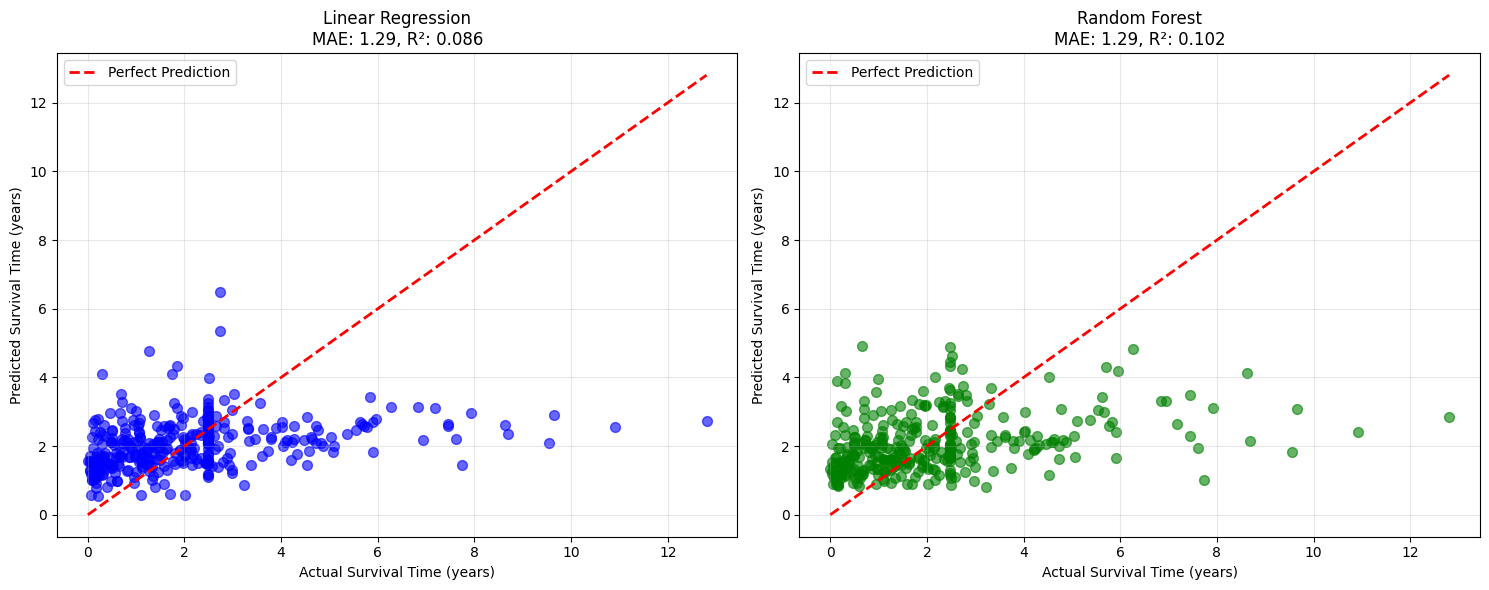

In [32]:
# 1. Predicted vs Actual scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Linear Regression
ax1.scatter(y_test_time, y_pred_lr, alpha=0.6, color='blue', s=50)
ax1.plot([y_test_time.min(), y_test_time.max()], 
         [y_test_time.min(), y_test_time.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Survival Time (years)')
ax1.set_ylabel('Predicted Survival Time (years)')
ax1.set_title(f'Linear Regression\nMAE: {lr_mae:.2f}, R²: {lr_r2:.3f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Random Forest
ax2.scatter(y_test_time, y_pred_rf, alpha=0.6, color='green', s=50)
ax2.plot([y_test_time.min(), y_test_time.max()], 
         [y_test_time.min(), y_test_time.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Survival Time (years)')
ax2.set_ylabel('Predicted Survival Time (years)')
ax2.set_title(f'Random Forest\nMAE: {rf_mae:.2f}, R²: {rf_r2:.3f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Residual plots reveal if there are patterns in the errors

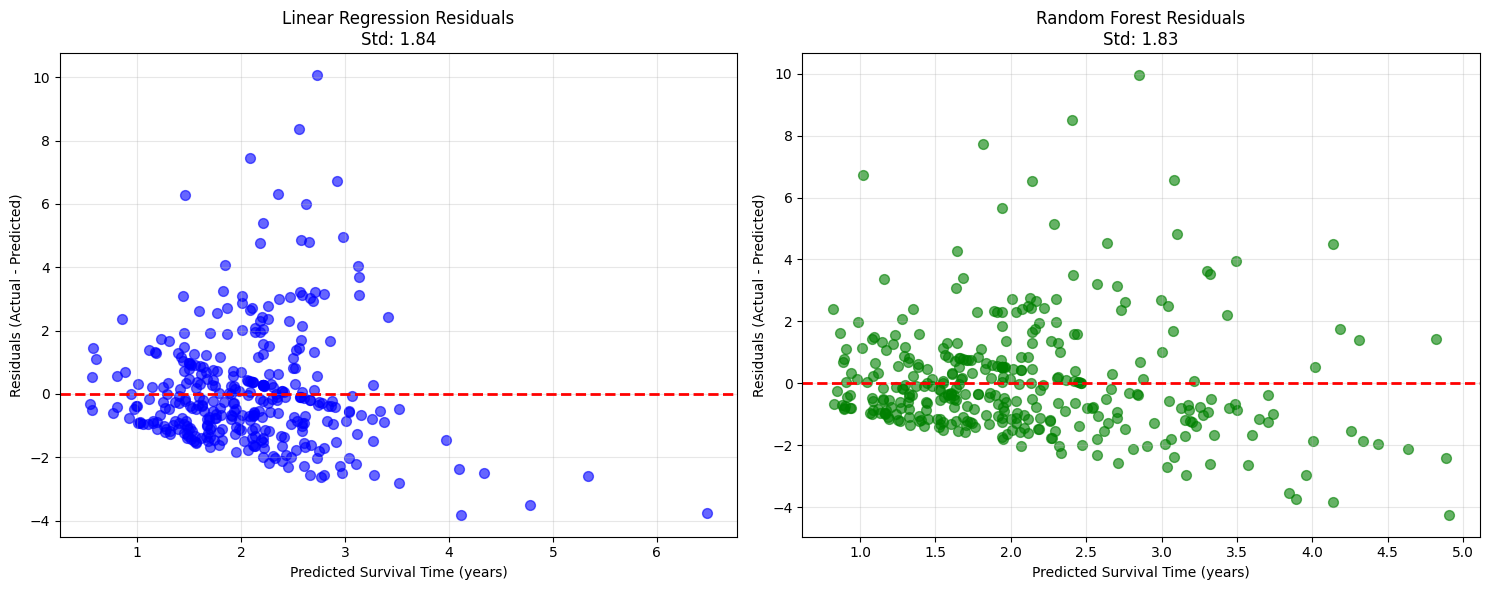

In [33]:
# 2. Residuals plot (errors)
residuals_lr = y_test_time - y_pred_lr
residuals_rf = y_test_time - y_pred_rf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Linear Regression residuals
ax1.scatter(y_pred_lr, residuals_lr, alpha=0.6, color='blue', s=50)
ax1.axhline(y=0, color='r', linestyle='--', lw=2)
ax1.set_xlabel('Predicted Survival Time (years)')
ax1.set_ylabel('Residuals (Actual - Predicted)')
ax1.set_title(f'Linear Regression Residuals\nStd: {residuals_lr.std():.2f}')
ax1.grid(True, alpha=0.3)

# Random Forest residuals
ax2.scatter(y_pred_rf, residuals_rf, alpha=0.6, color='green', s=50)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Survival Time (years)')
ax2.set_ylabel('Residuals (Actual - Predicted)')
ax2.set_title(f'Random Forest Residuals\nStd: {residuals_rf.std():.2f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Error distributions show the spread and frequency of prediction errors

/tmp/ipykernel_5052/3271093730.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_for_box, labels=['Linear Regression', 'Random Forest'])


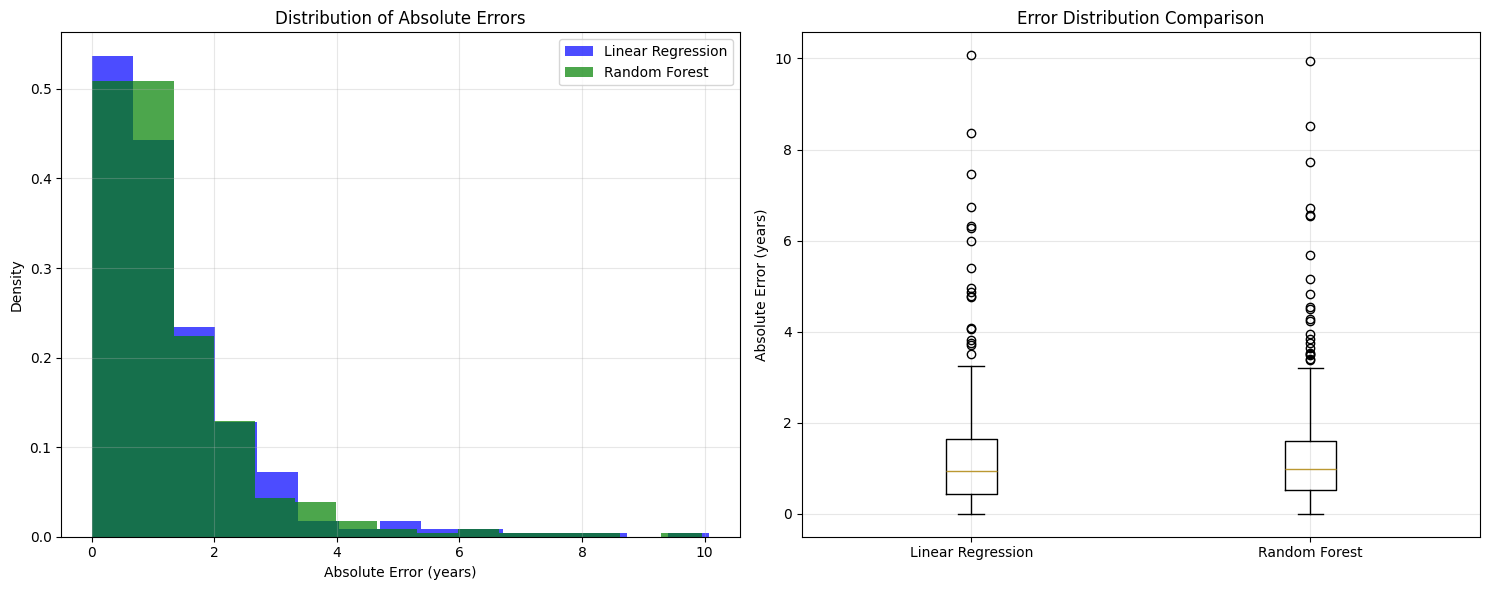

In [34]:
# 3. Error distribution comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Absolute errors
abs_errors_lr = np.abs(residuals_lr)
abs_errors_rf = np.abs(residuals_rf)

ax1.hist(abs_errors_lr, bins=15, alpha=0.7, color='blue', label='Linear Regression', density=True)
ax1.hist(abs_errors_rf, bins=15, alpha=0.7, color='green', label='Random Forest', density=True)
ax1.set_xlabel('Absolute Error (years)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Absolute Errors')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot comparison
data_for_box = [abs_errors_lr, abs_errors_rf]
ax2.boxplot(data_for_box, labels=['Linear Regression', 'Random Forest'])
ax2.set_ylabel('Absolute Error (years)')
ax2.set_title('Error Distribution Comparison')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

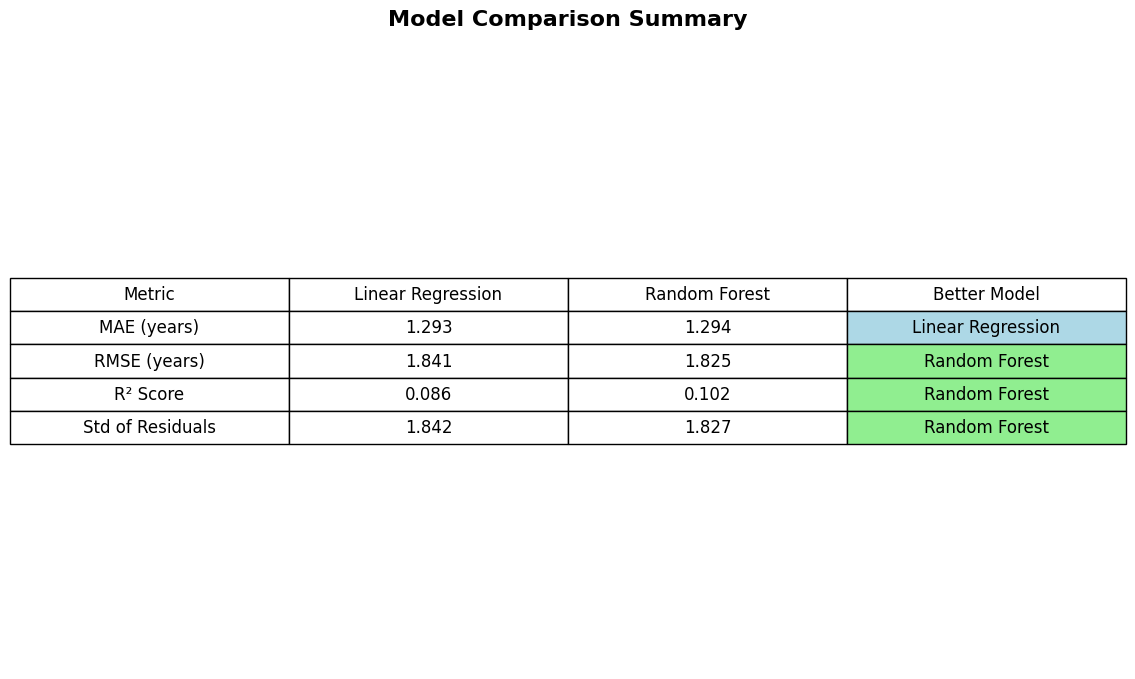

In [35]:
# 4. Summary visualization with key insights
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create a comprehensive comparison table
summary_data = {
    'Metric': ['MAE (years)', 'RMSE (years)', 'R² Score', 'Std of Residuals'],
    'Linear Regression': [lr_mae, lr_rmse, lr_r2, residuals_lr.std()],
    'Random Forest': [rf_mae, rf_rmse, rf_r2, residuals_rf.std()],
    'Better Model': [
        'Random Forest' if rf_mae < lr_mae else 'Linear Regression',
        'Random Forest' if rf_rmse < lr_rmse else 'Linear Regression', 
        'Random Forest' if rf_r2 > lr_r2 else 'Linear Regression',
        'Random Forest' if residuals_rf.std() < residuals_lr.std() else 'Linear Regression'
    ]
}

summary_df = pd.DataFrame(summary_data)

# Hide axes
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=summary_df.round(3).values,
                colLabels=summary_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.25, 0.25, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)

# Color code the "Better Model" column
for i in range(1, len(summary_df) + 1):
    if summary_df.iloc[i-1]['Better Model'] == 'Random Forest':
        table[(i, 3)].set_facecolor('#90EE90')  # Light green
    else:
        table[(i, 3)].set_facecolor('#ADD8E6')  # Light blue

plt.title('Model Comparison Summary', fontsize=16, fontweight='bold', pad=20)
plt.show()



## Prediction analysis

In [36]:
# Simple prediction analysis
print("PREDICTION ANALYSIS:")
print("=" * 30)

# Show some example predictions vs actual
comparison_df = pd.DataFrame({
    'Actual': y_test_time.values[:10],
    'LR_Predicted': y_pred_lr[:10], 
    'RF_Predicted': y_pred_rf[:10]
})
comparison_df['LR_Error'] = abs(comparison_df['Actual'] - comparison_df['LR_Predicted'])
comparison_df['RF_Error'] = abs(comparison_df['Actual'] - comparison_df['RF_Predicted'])

print("Sample Predictions (first 10 patients):")
print(comparison_df.round(2))

print(f"\nActual survival time stats:")
print(f"  Mean: {y_test_time.mean():.2f} years")
print(f"  Median: {y_test_time.median():.2f} years") 
print(f"  Range: {y_test_time.min():.2f} - {y_test_time.max():.2f} years")

print(f"\nBaseline model predictions:")
print(f"  Mean predicted (RF): {y_pred_rf.mean():.2f} years")
print(f"  Range predicted (RF): {y_pred_rf.min():.2f} - {y_pred_rf.max():.2f} years")

PREDICTION ANALYSIS:
Sample Predictions (first 10 patients):
   Actual  LR_Predicted  RF_Predicted  LR_Error  RF_Error
0    2.73          6.48          4.26      3.75      1.53
1    0.08          1.48          1.08      1.40      1.00
2    4.04          2.01          2.44      2.03      1.60
3    0.76          2.53          2.29      1.77      1.53
4    1.45          2.11          2.36      0.66      0.91
5    2.48          2.06          1.84      0.42      0.64
6    0.17          0.77          0.83      0.60      0.66
7    1.91          1.90          1.45      0.01      0.46
8    1.78          2.50          2.42      0.72      0.64
9    5.96          2.80          4.19      3.16      1.77

Actual survival time stats:
  Mean: 2.13 years
  Median: 1.75 years
  Range: 0.00 - 12.80 years

Baseline model predictions:
  Mean predicted (RF): 2.07 years
  Range predicted (RF): 0.82 - 4.91 years


In [37]:
# Establish baseline performance benchmark
print("BASELINE ESTABLISHED:")
print("=" * 40)
print(f"Model: {best_model}")
print(f"Features: {features}")
print(f"Training samples: {len(X_train_events)}")
print(f"Test samples: {len(X_test_events)}")
print(f"Baseline MAE: {best_mae:.2f} years")
print(f"Baseline R²: {best_r2:.3f}")

print(f"\nPerformance targets for future models:")
print(f"✓ MAE should be < {best_mae:.2f} years")
print(f"✓ R² should be > {best_r2:.3f}")

print(f"\nLimitations of this baseline:")
print("- Only predicts for patients with events (deaths)")
print("- Doesn't handle censored data properly") 
print("- Simple approach but establishes clear benchmark")

BASELINE ESTABLISHED:
Model: Linear Regression
Features: ['BM_BLAST', 'HB', 'PLT']
Training samples: 1400
Test samples: 350
Baseline MAE: 1.29 years
Baseline R²: 0.086

Performance targets for future models:
✓ MAE should be < 1.29 years
✓ R² should be > 0.086

Limitations of this baseline:
- Only predicts for patients with events (deaths)
- Doesn't handle censored data properly
- Simple approach but establishes clear benchmark


In [40]:
# SUMMARY AND BENCHMARKS FOR FUTURE MODELS

print("\n" + "="*60)
print("BASELINE MODEL SUMMARY & BENCHMARKS")
print("="*60)

print(f"\nBest performing baseline model: {best_model}")
print(f"Benchmark to beat:")
print(f"  - Mean Absolute Error: {best_mae:.3f} years")
print(f"  - Root Mean Squared Error: {min(mean_rmse, blast_rmse):.3f} years")

print(f"\nFor your next advanced model (Cox regression, Random Survival Forest, etc.) to be successful:")
print(f"  ✓ Should achieve MAE < {best_mae:.3f} years")
print(f"  ✓ Should achieve RMSE < {min(mean_rmse, blast_rmse):.3f} years")

print(f"\nKey insights from baseline analysis:")
if blast_mae < mean_mae:
    print(f"  • BM_BLAST shows predictive value (improves MAE by {((mean_mae - blast_mae) / mean_mae) * 100:.1f}%)")
    print(f"  • Patients with BM_BLAST > {blast_baseline.threshold:.1f}% have worse prognosis")
else:
    print(f"  • BM_BLAST threshold doesn't improve prediction over simple mean")
    print(f"  • Consider other features (HB, PLT) or different thresholds")


print(f"\nThe advanced survival model should beat the MAE = {best_mae:.3f} years")


BASELINE MODEL SUMMARY & BENCHMARKS

Best performing baseline model: Linear Regression
Benchmark to beat:
  - Mean Absolute Error: 1.293 years


NameError: name 'mean_rmse' is not defined